In [ ]:
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')

# calculate moving average DataFrame using pandas' rolling_mean
import pandas as pd
# a rolling mean is a moving average, right?
sma = data.rolling(50).mean()

Stat                 Bollinger_Strategy
-------------------  --------------------
Start                2019-01-01
End                  2024-06-21
Risk-free rate       0.00%

Total Return         93.10%
Daily Sharpe         0.72
Daily Sortino        1.09
CAGR                 12.78%
Max Drawdown         -35.12%
Calmar Ratio         0.36

MTD                  1.63%
3m                   0.38%
6m                   6.39%
YTD                  5.81%
1Y                   16.06%
3Y (ann.)            4.45%
5Y (ann.)            10.31%
10Y (ann.)           -
Since Incep. (ann.)  12.78%

Daily Sharpe         0.72
Daily Sortino        1.09
Daily Mean (ann.)    13.93%
Daily Vol (ann.)     19.36%
Daily Skew           -0.88
Daily Kurt           17.91
Best Day             9.27%
Worst Day            -12.21%

Monthly Sharpe       0.70
Monthly Sortino      1.24
Monthly Mean (ann.)  12.03%
Monthly Vol (ann.)   17.20%
Monthly Skew         -0.35
Monthly Kurt         0.51
Best Month           12.35%
Worst Month

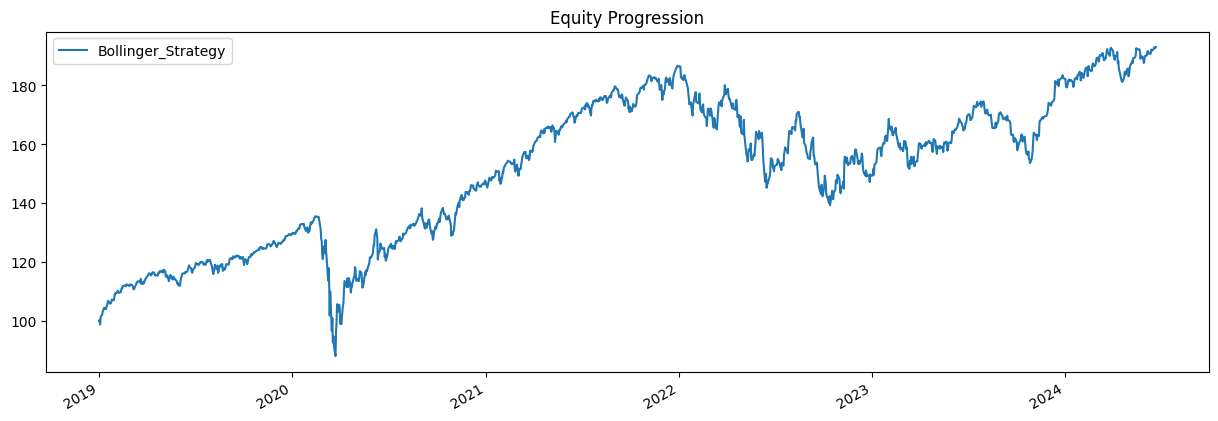

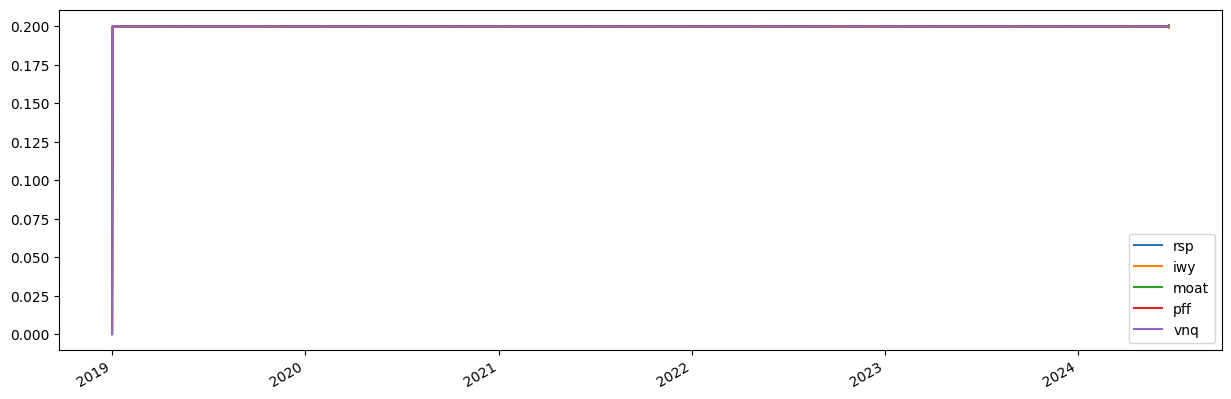

In [8]:
import bt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 定义布林带逻辑的算法
class BollingerAlgo(bt.Algo):
    def __init__(self, lookback=200, std_dev=2):
        super(BollingerAlgo, self).__init__()
        self.lookback = lookback
        self.std_dev = std_dev

    def __call__(self, target):
        # 获取数据
        prices = target.universe.loc[:target.now]
        
        # 计算年线和布林带
        ma = prices.rolling(window=self.lookback).mean()
        std = prices.rolling(window=self.lookback).std()
        upper_band = ma + self.std_dev * std
        lower_band = ma - self.std_dev * std
        
        # 计算20%阈值
        upper_threshold = ma * 1.2
        lower_threshold = ma * 0.8
        
        # 初始化权重
        weights = pd.Series(0, index=prices.columns)
        
        # 获取当前价格
        current_prices = prices.iloc[-1]
        
        # 根据布林带逻辑设置权重
        for asset in prices.columns:
            if current_prices[asset] > upper_threshold[asset].iloc[-1]:
                weights[asset] = 0  # 卖出
            elif current_prices[asset] < lower_threshold[asset].iloc[-1]:
                weights[asset] = 1  # 买入
            else:
                weights[asset] = 1 / len(prices.columns)  # 等权分配
        
        # 设置权重
        target.temp['weights'] = weights
        return True

# # 定义风控算法
# class RiskManagementAlgo(bt.Algo):
#     def __init__(self, voo_data, max_drawdown=0.1):
#         super(RiskManagementAlgo, self).__init__()
#         self.voo_data = voo_data
#         self.max_drawdown = max_drawdown
#         self.high_water_mark = None

#     def __call__(self, target):
#         # 获取VOO的价格数据
#         prices = self.voo_data.loc[:target.now]
        
#         # 初始化高水位标记
#         if self.high_water_mark is None:
#             self.high_water_mark = prices.max()
        
#         # 更新高水位标记
#         self.high_water_mark = max(self.high_water_mark, prices.iloc[-1])
        
#         # 计算回撤
#         drawdown = (self.high_water_mark - prices.iloc[-1]) / self.high_water_mark
        
#         # 如果回撤超过最大回撤限制，清仓
#         if drawdown > self.max_drawdown:
#             target.temp['weights'] = pd.Series(0, index=target.universe.columns)
#         return True

# 获取数据
data = bt.get('RSP,IWY,MOAT,PFF,VNQ', start='2019-01-01')
voo_data = bt.get('VOO', start='2019-01-01')

# 创建策略
main_strategy = bt.Strategy('Bollinger_Strategy', 
                            [bt.algos.RunDaily(),
                             bt.algos.SelectAll(),
                             BollingerAlgo(),
                             # RiskManagementAlgo(voo_data['voo']),
                             bt.algos.WeighEqually(),
                             bt.algos.Rebalance()])

# 创建回测
main_backtest = bt.Backtest(main_strategy, data)

# 运行回测
result = bt.run(main_backtest)

# 打印结果
result.display()

# 绘制权益曲线
result.plot()

# 绘制资产权重变化图
result.plot_security_weights()

# 输出最新的持仓和买卖建议
latest_weights = result.get_security_weights().iloc[-1]
print("最新持仓:")
print(latest_weights)

# 生成买卖建议
buy_signals = latest_weights[latest_weights > 0].index.tolist()
sell_signals = latest_weights[latest_weights == 0].index.tolist()

print("\n买入建议:")
print(buy_signals)

print("\n卖出建议:")
print(sell_signals)

In [11]:
# 返回交易明细
# 获取交易明细
transactions = result.get_transactions()
print("\n交易明细:")
print(transactions)
transactions.to_csv("交易明细.csv")


交易明细:
                          price  quantity
Date       Security                      
2019-01-02 iwy        68.554123    2917.0
           moat       38.847393    5148.0
           pff        25.921526    7715.0
           rsp        83.257751    2402.0
           vnq        60.123150    3326.0
...                         ...       ...
2024-06-20 iwy       214.759995      10.0
           moat       86.470001     -25.0
           pff        31.520000       3.0
           rsp       165.380005      -4.0
           vnq        83.760002       8.0

[6692 rows x 2 columns]


Stat                 Bollinger_Strategy    Benchmark_Strategy
-------------------  --------------------  --------------------
Start                2019-01-01            2019-01-01
End                  2024-06-21            2024-06-21
Risk-free rate       0.00%                 0.00%

Total Return         93.10%                138.27%
Daily Sharpe         0.72                  0.88
Daily Sortino        1.09                  1.36
CAGR                 12.78%                17.20%
Max Drawdown         -35.12%               -33.99%
Calmar Ratio         0.36                  0.51

MTD                  1.63%                 3.54%
3m                   0.38%                 4.58%
6m                   6.39%                 15.91%
YTD                  5.81%                 15.24%
1Y                   16.06%                26.97%
3Y (ann.)            4.45%                 10.62%
5Y (ann.)            10.31%                14.95%
10Y (ann.)           -                     -
Since Incep. (ann.)  12.78

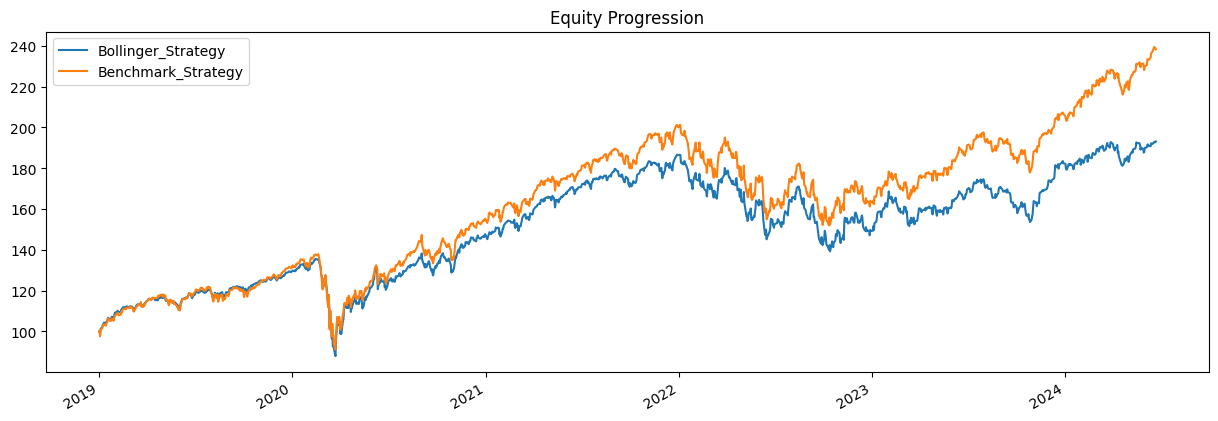

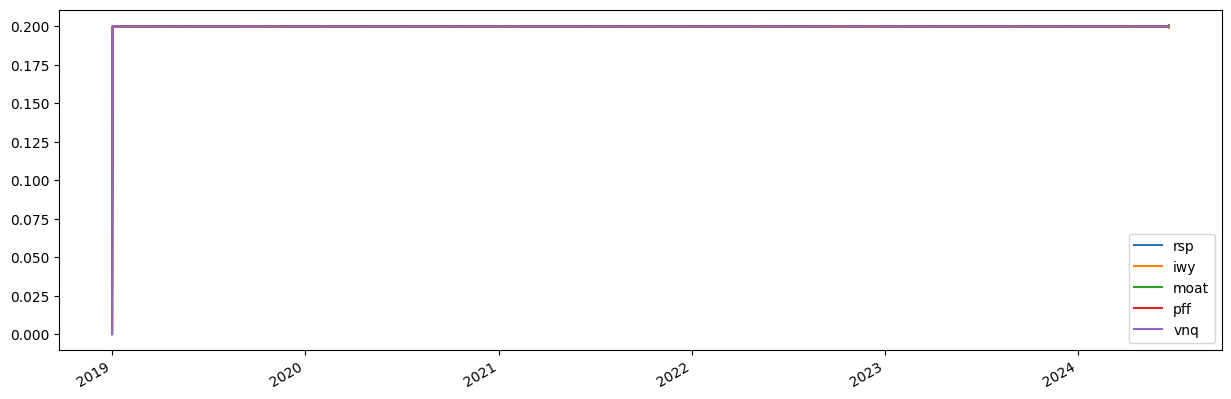

In [7]:
# 创建基准策略，只买入VOO，不卖出
benchmark_strategy = bt.Strategy('Benchmark_Strategy', 
                                 [bt.algos.RunOnce(),
                                  bt.algos.SelectAll(),
                                  bt.algos.WeighEqually(),
                                  bt.algos.Rebalance()])
# 创建回测
main_backtest = bt.Backtest(main_strategy, data)
benchmark_backtest = bt.Backtest(benchmark_strategy, voo_data)

# 运行回测
results = bt.run(main_backtest, benchmark_backtest)

# 打印结果
results.display()

# 绘制权益曲线
results.plot()

# 绘制资产权重变化图
results.plot_security_weights()

In [15]:
# 定位最大回撤时间段
def find_max_drawdown_period(equity_curve):
    rolling_max = equity_curve.cummax()
    drawdowns = equity_curve / rolling_max - 1.0
    max_drawdown = drawdowns.min()
    end_date = drawdowns.idxmin()
    start_date = (equity_curve[:end_date]).idxmax()
    return start_date, end_date, max_drawdown

# 获取主要策略的权益曲线
equity_curve = results.get('Benchmark_Strategy').prices

# 找到最大回撤时间段
start_date, end_date, max_drawdown = find_max_drawdown_period(equity_curve)
print(f"最大回撤时间段: 从 {start_date} 到 {end_date}, 最大回撤: {max_drawdown:.2%}")

最大回撤时间段: 从 2020-02-19 00:00:00 到 2020-03-23 00:00:00, 最大回撤: -33.99%
